# Final Presentation - Customer satisfication in hotel industry
### Course: `Data Analysis Mathematics, Algorithms and Modeling`
### Team 7 - Members:
- **Tilvan Madalina**  - Student number: 9058215
- **Wesley Jayavanti** - Student number: 9019852
- **Yun-Chen Wang**    - Student number: 9040873

---

## About this presentation:
1. Implement comprehensive data analysis, a mix of Normality, F, T, Chi-Square, or ANOVA tests, and add a discussion of their relevance to the term project.
2. Implement Dimensionality Reduction techniques, do cleanup and finalize preparation of a final data set, adding a discussion of their relevance to your term project.
3. Implement and display the result of implementing time Series and a relevant set of Clustering, Regression, Classification, and Probabilistic Reasoning algorithms, finally adding a discussion of their relevance to your term project.
4. Implement Probabilistic Reasoning adequately to the purposes and targets of your term project.
5. Prepare a 10-15 minute presentation using the notebook as a guide.

## Use Case

## Environment setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from IPython.display import display

import statsmodels.formula.api as smf

from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline

## Clean dataset

In [2]:
# Load cleaned dataset
path = "../dataset/clean_df.csv"
clean_df = pd.read_csv(path)
print(f"Load dataframe from {path}, Shape: {clean_df.shape}")
display(clean_df.head()) # print the first 5 rows of the dataset

Load dataframe from ../dataset/clean_df.csv, Shape: (1048575, 85)


,Destination_country_id,Visitors_country_id,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel.stars,...,Trip_type_couple,Trip_type_family,Trip_type_friends,Trip_type_solo,Trip_type_unknown,Reviewer_rank_Reviewer,Reviewer_rank_Senior Contributor,Reviewer_rank_Senior Reviewer,Reviewer_rank_Top Contributor,Reviewer_rank_Unknown
0,59,1,3,2,3,3,3,3,4,5,...,0,0,0,0,0,1,0,0,0,0
1,96,1,4,5,5,3,5,4,5,3,...,0,1,0,0,0,0,0,0,1,0
2,59,1,5,5,5,3,5,5,4,5,...,0,0,0,0,0,0,0,0,0,1
3,199,1,4,3,5,4,5,4,4,5,...,0,0,0,1,0,0,0,1,0,0
4,49,1,3,5,4,3,5,4,5,3,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
# Replace all non-alphanumeric characters in column names with underscores
# clean_df.columns = clean_df.columns.str.replace(r'\W+', '_', regex=True)
clean_df.to_csv("../dataset/clean_df_ver2.csv", index=False)

## Hypothesis Testing
### T-Test
Compare if two groups of data are similar or different?  
H0: asume two groups of data are similar  
H1: asume two groups of data are not similar (different)  
``` python
if p_value < alpha:
    # H1, two groups are different
    print("\t Reject (H0)\n") 
else:
    # H0, two groups are simillar
    print("\t Accept (H0)\n") 
```

We create a function for both t-test, as shown bellow.

In [ ]:
def test_two_groups(_dataframe, _start1, _end1, _start2, _end2, mode="t"):
    """
    _dataframe: input dataframe
    _start1, _end1 : starting and ending date time for group1
    _start2, _end2 : starting and ending date time for group2
    mode: 
        T-test: "t", "T" or "t_test"
    """
    group1 = _dataframe[
        (_dataframe["Date_of_review"] >= _start1) &
        (_dataframe["Date_of_review"] <= _end1 )
        ]["Overall_rating"].dropna()

    group2 = _dataframe[
        (_dataframe["Date_of_review"] >= _start2) &
        (_dataframe["Date_of_review"] <= _end2)
        ]["Overall_rating"].dropna()

    # print(f"Numbers of datas in Group1: {len(group1)}")
    # print(f"Numbers of datas in Group2: {len(group2)}")
    
    if mode in {"t_test", "t", "T"}:
        _stat, p_value = ttest_ind(group1, group2, equal_var=False)
        print(f"T-score: {_stat:.4f}, P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("\t Reject (H0)\n") # H1, two groups are different
    else:
        print("\t Accept (H0)\n") # H0, two groups are simillar

    return _stat, p_value

### Compare the difference of "Overall ratings" between two groups, each groups contain different time period, by t-test and z-test.

In [ ]:
# Fix the datatime format for the column "Date_of_review"
rating_df["Date_of_review"]= pd.to_datetime(rating_df["Date_of_review"], errors="coerce")

## Dimensionality Reduction

### Principal Component Analysis (PCA)

In [ ]:
def perform_pca_analysis(_df: pd.DataFrame):
    _df = _df.select_dtypes(include=['number']).dropna()

    # Standardize the features (PCA is sensitive to scale)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(_df)

    # Apply PCA (keep all components)
    pca = PCA(n_components=len(_df.columns))
    pca.fit(scaled_features)

    # Get explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Find the minimum number of components that explain at least 90% variance
    num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 since index starts from 0

    # Plot explained variance
    plt.figure(figsize=(18, 8))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', label="Explained Variance")
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='r', label="Cumulative Explained Variance")
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Explained and Cumulative Variance by Principal Components')
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create a DataFrame to show explained variance
    explained_variance_df = pd.DataFrame({
        "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance))],
        "Explained Variance Ratio": explained_variance,
        "Cumulative Variance": cumulative_variance
    })

    # Print explained variance DataFrame
    print("\nExplained Variance Analysis:")
    print(explained_variance_df)

    # Get PCA component vectors (eigenvectors)
    pca_components_df = pd.DataFrame(pca.components_, columns=_df.columns, index=[f"PC{i+1}" for i in range(len(_df.columns))])

    # Print PCA component vectors
    print("\nPCA Component Vectors (Eigenvectors):")
    print(pca_components_df)
    return num_components_90  # Return the number of components needed to explain at least 90% variance

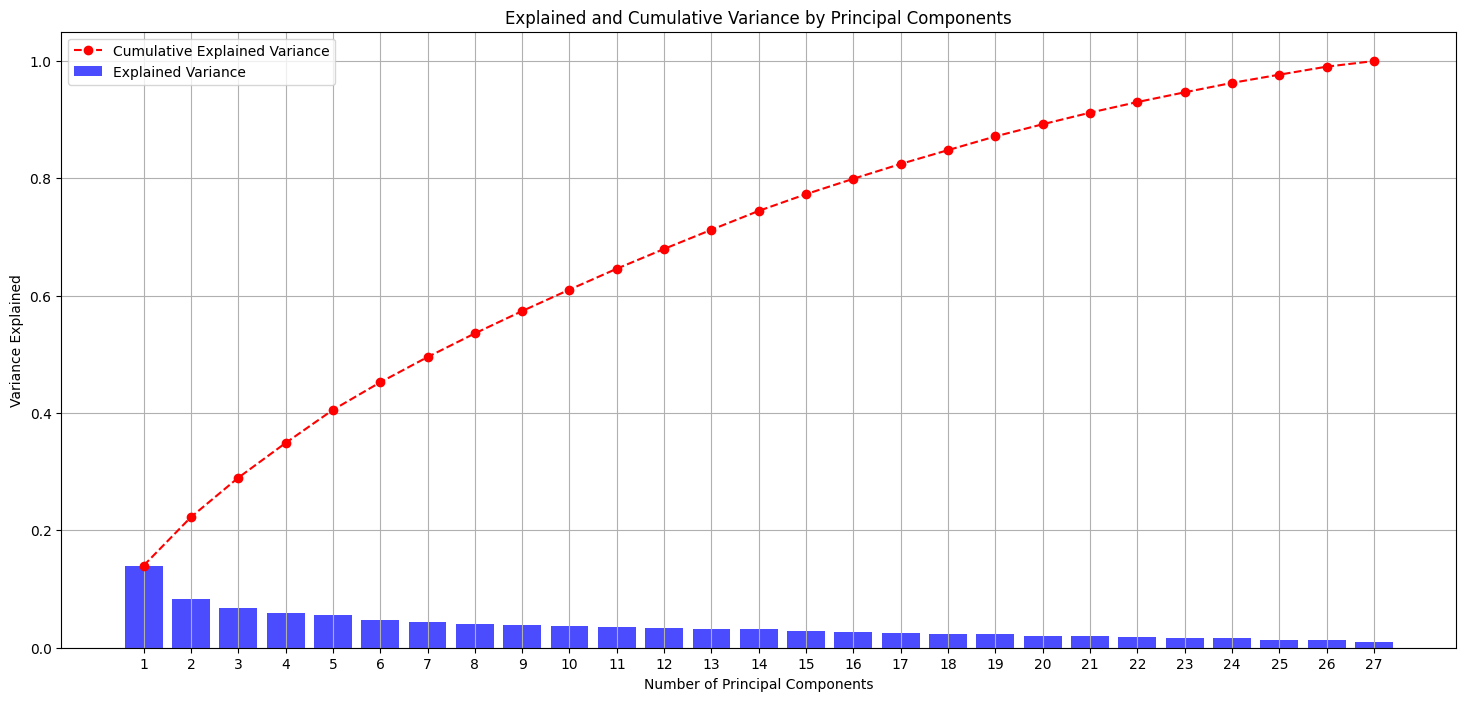


Explained Variance Analysis:
   Principal Component  Explained Variance Ratio  Cumulative Variance
0                  PC1                      0.14                 0.14
1                  PC2                      0.08                 0.22
2                  PC3                      0.07                 0.29
3                  PC4                      0.06                 0.35
4                  PC5                      0.06                 0.41
5                  PC6                      0.05                 0.45
6                  PC7                      0.04                 0.50
7                  PC8                      0.04                 0.54
8                  PC9                      0.04                 0.57
9                 PC10                      0.04                 0.61
10                PC11                      0.04                 0.65
11                PC12                      0.03                 0.68
12                PC13                      0.03            

In [ ]:
num_pcs = perform_pca_analysis(highc_filtered_df)
print(f"\nMinimum number of PCA components needed for 90% variance: {num_pcs}")

## Time Series

This part provides a comprehensive analysis of historical review data to identify trends and seasonal patterns in customer ratings over time. Utilizing statistical methods such as moving averages and seasonal decomposition. We tried to ebserve the time trend of overall-ratings in our dataset. First, we review what we have done in the previous work.

Historical trend of the mean overall rating scores

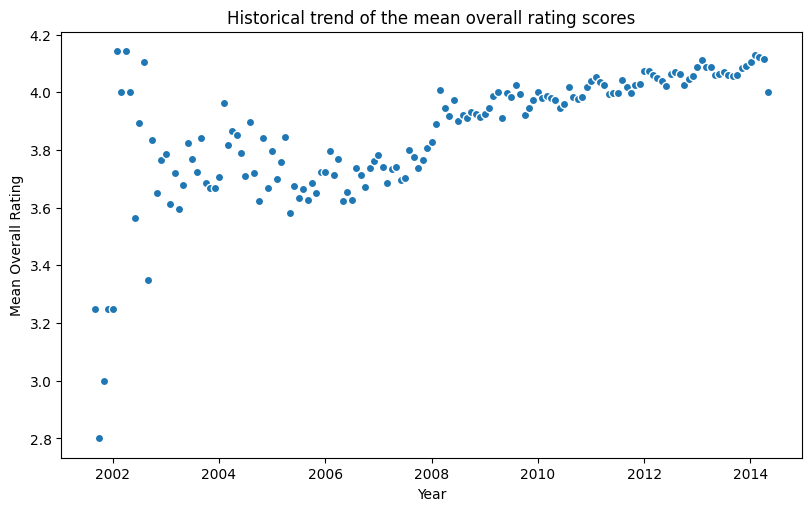

In [ ]:
# Change the date column to be of type datetime
review_date = pd.to_datetime(rating_df['Date_of_review'])

# Extract the year from the review_date column
review_year_month = review_date.dt.to_period('M')

# Group by year and calculate the mean overall rating
mean_ratings_monthly = rating_df.groupby(review_year_month)['Overall_rating'].mean()
mean_ratings_monthly.index = mean_ratings_monthly.index.to_timestamp()

# Scatter Plot
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
ax.scatter(mean_ratings_monthly.index, mean_ratings_monthly.values, edgecolors='white')
ax.set_title('Historical trend of the mean overall rating scores')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Overall Rating')

# Show ticks from 2002 to 2016 with an interval of 2 years
ticks = pd.date_range(start='2002-01-01', end='2016-01-01', freq='2Y')
plt.xticks(ticks, labels=[tick.strftime('%Y') for tick in ticks])

plt.show()

Total number of rating by year

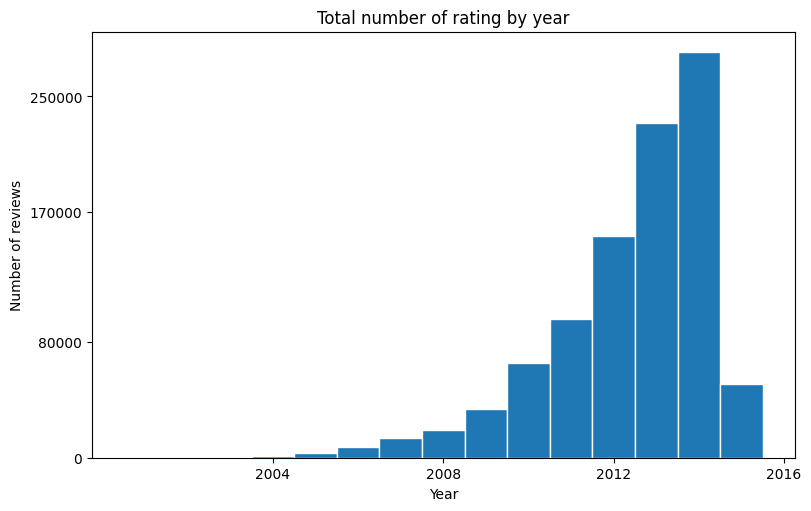

In [ ]:
# Extract the year from the review_date column
review_year = review_date.dt.year

# Histogram
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
ax.hist(review_year, bins=range(2001, 2017), edgecolor='white', align='left')
ax.set_title('Total number of rating by year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of reviews')

# Set x-axis and y-axis tick marks and labels
x_ticks = np.linspace(2004, 2016, 4)
plt.xticks(x_ticks)

y_ticks = np.linspace(0, 250000, 4)
y_ticks = [round(tick, -4) for tick in y_ticks] # round to the nearest tens of thousands (4 zeros)
plt.yticks(y_ticks)

plt.show()

#### Question: It shows that the overall_rating increases in our dataset. But is there any other patterns inside our data? 

### 8.1 Generate one time series by transforming your existing data sources.

Convert the `timing information` to datetime, and set `Date_of_review` as index.

In [ ]:
path = "../dataset/The final data set (uncentered and unscaled variables).csv"
rating_df = pd.read_csv(path)
print(f"Shape of dataset: {rating_df.shape}")

# Convert 'Date_of_review' to datetime
rating_df['Date_of_review'] = pd.to_datetime(rating_df['Date_of_review'])

# Set 'Date_of_review' as the index
rating_df.set_index('Date_of_review', inplace=True)

rating_df.head()

Shape of dataset: (1048575, 80)


,Visitors_country_name,Destination_country_name,Hotel_id,Reviewer_id,Review_id,Destination_country_id,Visitors_country_id,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Trip_type,Reviewer_rank,Hotel.stars,Hotel.price,Hotel.distance,Hotel.noofrooms,Suites,Family.Rooms,Microwave,Air.Conditioning,Minibar,Refrigerator.in.room,Bar.Lounge,Kitchenette,Free.Parking,Self.Serve.Laundry,Business.Centre.with.Internet.Access,Conference.Facilities,Meeting.Rooms,Banquet.Room,Casino.and.Gambling,Babysitting,Dry.Cleaning,Multilingual.Staff,Airport.Transportation,Free.Breakfast,Children.Activities...Kid...Family.Friendly..,Laundry.Service,Concierge,Room.Service,Restaurant,Shuttle.Bus.Service,Free.Internet,Free.High.Speed.Internet...WiFi..,Paid.Wifi,Paid.Internet,Public.Wifi,Ski.In...Ski.Out,Fitness.Centre.with.Gym...Workout.Room,Spa,Tennis.Court,Hot.Tub,Pool,Golf.course,Beach,Wheelchair.access,Reduced.mobility.rooms,Non.Smoking.Hotel,Non.Smoking.Rooms,Smoking.rooms.available,Pets.Allowed...Dog...Pet.Friendly..,Destination_country_GDP,Visitors_country_GDP,Destination_country_pdi,Destination_country_idv,Destination_country_mas,Destination_country_uai,Destination_country_lto,Destination_country_ivr,Visitors_country_pdi,Visitors_country_idv,Visitors_country_mas,Visitors_country_uai,Visitors_country_lto,Visitors_country_ivr
Date_of_review,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-06-09,Afghanistan,Egypt,d302323,BEFE48CEC37A8BAC68FC5471B7D52A68,131620232,59,1,3,2.0,3.0,3.0,3.0,3.0,4.0,business,Reviewer,5.0,151.0,8.05,409.0,1,1,0,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,3314.5,664.8,70,25,45,80,7,4,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-21,Afghanistan,Japan,d1115809,390FEEFF2C67C9ACC376C133F3E5AD9D,223296192,96,1,4,NaN,NaN,NaN,5.0,4.0,5.0,family,Top Contributor,3.0,94.0,4.99,250.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,38633.7,664.8,54,46,95,92,88,42,NaN,NaN,NaN,NaN,NaN,NaN
NaT,Afghanistan,Egypt,d300669,452C85191D400F6C83F249B4990CBD74,254401713,59,1,5,NaN,5.0,NaN,5.0,5.0,NaN,business,NaN,5.0,181.0,1.13,855.0,1,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,0,1,1,0,0,1,0,1,1,1,0,0,1,0,0,1,0,1,3314.5,664.8,70,25,45,80,7,4,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,Afghanistan,United Kingdom,d187989,B112C906DAA206F9F2EA9613526DCD3A,23343685,199,1,4,3.0,5.0,4.0,5.0,NaN,4.0,solo,Senior Reviewer,5.0,668.0,4.51,214.0,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,41781.1,664.8,35,89,66,35,51,69,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-21,Afghanistan,Croatia,d601897,17552C71896B64C6EFCC959E1551F412,47403276,49,1,3,5.0,4.0,3.0,5.0,NaN,5.0,solo,Senior Contributor,NaN,77.0,2.09,49.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,13597.9,664.8,73,33,40,80,58,33,NaN,NaN,NaN,NaN,NaN,NaN


Resample the data monthly and calculate the mean of `Overall_rating`, store the results into `monthly_data`.

In [ ]:
# Resample the data monthly and calculate the mean of 'Overall_rating'
monthly_data = rating_df['Overall_rating'].resample('M').mean()

# Display the first few entries of the resampled data
monthly_data.head()

Date_of_review
2002-09-30    3.25
2002-10-31    2.80
2002-11-30    3.00
2002-12-31    3.25
2003-01-31    3.25
Name: Overall_rating, dtype: float64

### 8.2 Identify a pattern or a trend in the time series.
This section will be performed in further section, the `Deseasonalize`.

### 8.3 Apply the Augmented Dickey-Fuller (ADF) test to check if stationarity

In [ ]:
adf_test = stattools.adfuller(monthly_data)

adf_statistic = adf_test[0]   # Test statistic
p_value = adf_test[1]         # p-value
critical_values = adf_test[4] # Critical values at 1%, 5%, and 10% levels

print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

if p_value < 0.05:
    print("The time series is stationary (Reject H0).")
else:
    print("The time series is non-stationary (Fail to reject H0).")


ADF Statistic: -0.39383188205373937
P-Value: 0.9111235494991501
Critical Values:
	1%: -3.4782936965183815
	5%: -2.882567574015525
	10%: -2.5779830117488745
The time series is non-stationary (Fail to reject H0).


The ADF statistic of -0.39 is higher than the critical values at the 1%, 5%, and 10% significance levels, which indicates that the time series is non-stationary. Additionally, the p-value of 0.91 exceeds the 0.05 threshold, meaning we fail to reject the null hypothesis. We conclude that the time series is non-stationary and may need to perform transformations such as differencing, detrending, or deseasonalizing before further analysis.

### 8.4 Calculate and plot the Moving Averages from the time series.

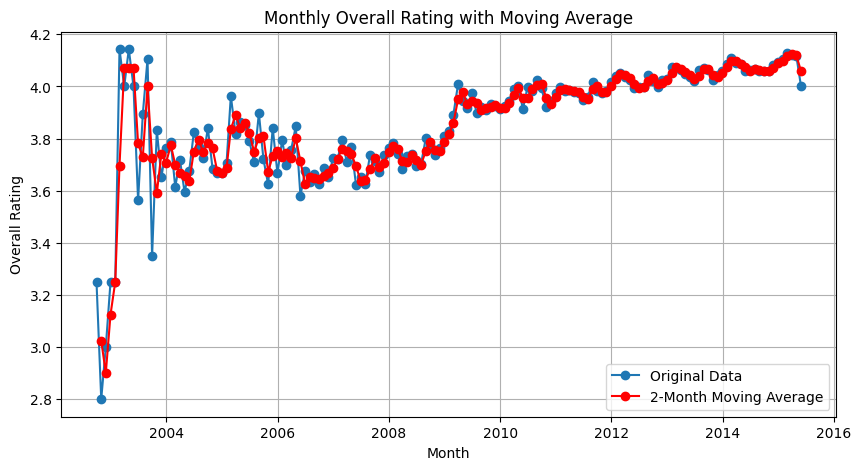

In [ ]:
# Calculate the moving average using a 2-year window
moving_average = monthly_data.rolling(window=2).mean()

# Plot the original time series and the moving average
plt.figure(figsize=(10, 5))
plt.plot(monthly_data, marker='o', linestyle='-', label="Original Data")
plt.plot(moving_average, marker='o', linestyle='-', color='red', label="2-Month Moving Average")
plt.title("Monthly Overall Rating with Moving Average")
plt.xlabel("Month")
plt.ylabel("Overall Rating")
plt.legend()
plt.grid()
plt.show()

Explanation:  
* The chart displays the monthly overall rating data over several years, marked by blue dots, showing the fluctuating nature of the ratings from month to month.
* A two-month moving average, depicted in red, smooths these fluctuations to illustrate the underlying trend, highlighting periods of improvement or decline in ratings.
* The moving average line generally stays above the 3.8 rating mark after 2008, indicating a relatively stable and positive trend in overall ratings during this period.

### 8.5 `Deseasonalize` the time series

#### 8.5.1 Model='additive'

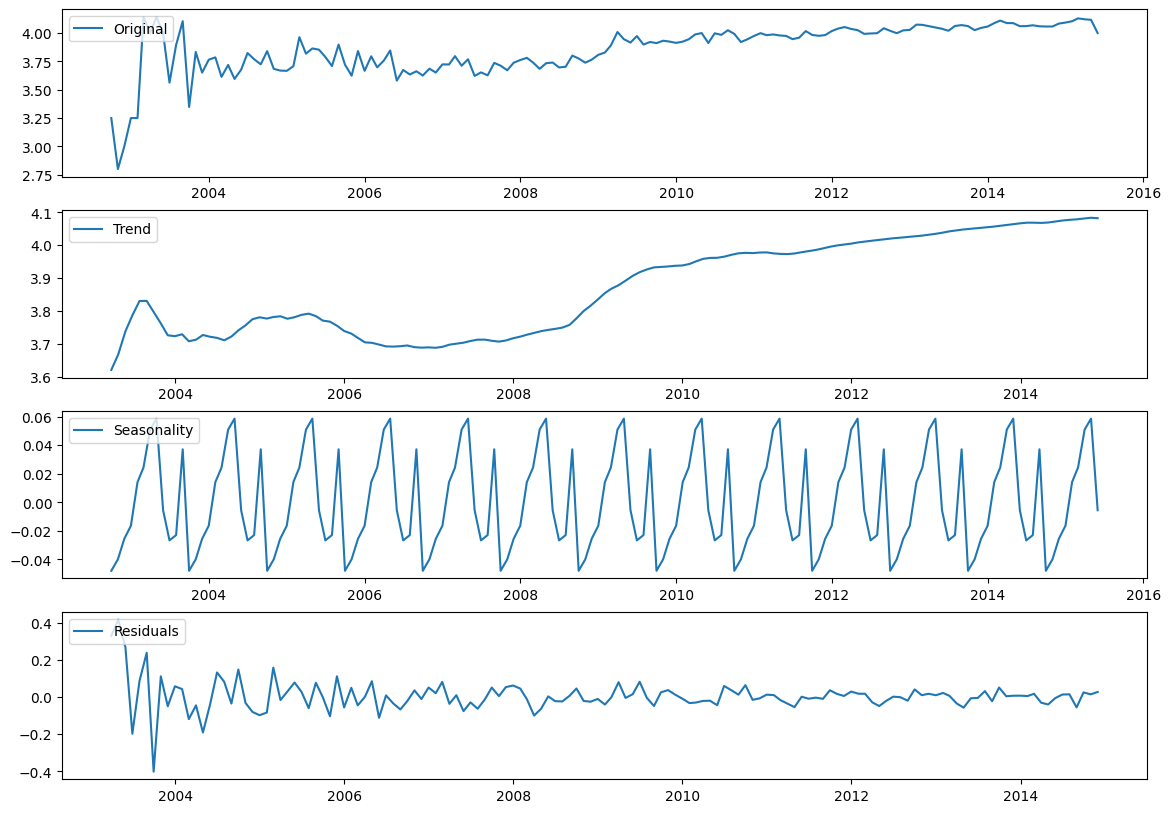

In [ ]:
# Perform seasonal decomposition of the annual data to identify trend and pattern
decomposition = seasonal_decompose(monthly_data.dropna(), model='additive')  # Assuming an additive model initially

# Plot the decomposition to visualize trend, seasonality, and residuals
plt.figure(figsize=(14, 10))

components = {
    'Original': decomposition.observed,
    'Trend': decomposition.trend,
    'Seasonality': decomposition.seasonal,
    'Residuals': decomposition.resid
}

for i, (label, component) in enumerate(components.items(), start=1):
    plt.subplot(4, 1, i)
    plt.plot(component, label=label)
    plt.legend(loc='upper left')

Additive Model Explanation:   
* The chart shows the decomposition of the time series into its constituent parts under the assumption of an additive model, where fluctuations in seasonality are consistent over time.
* Components of Additive Model: It displays four plots – the original data with minor fluctuations around 3.5 to 4.0, a slowly increasing trend suggesting a gradual improvement over time, relatively stable seasonal fluctuations, and small residuals indicating minor deviations from the model.

#### 8.5.2 Model='multiplicative'

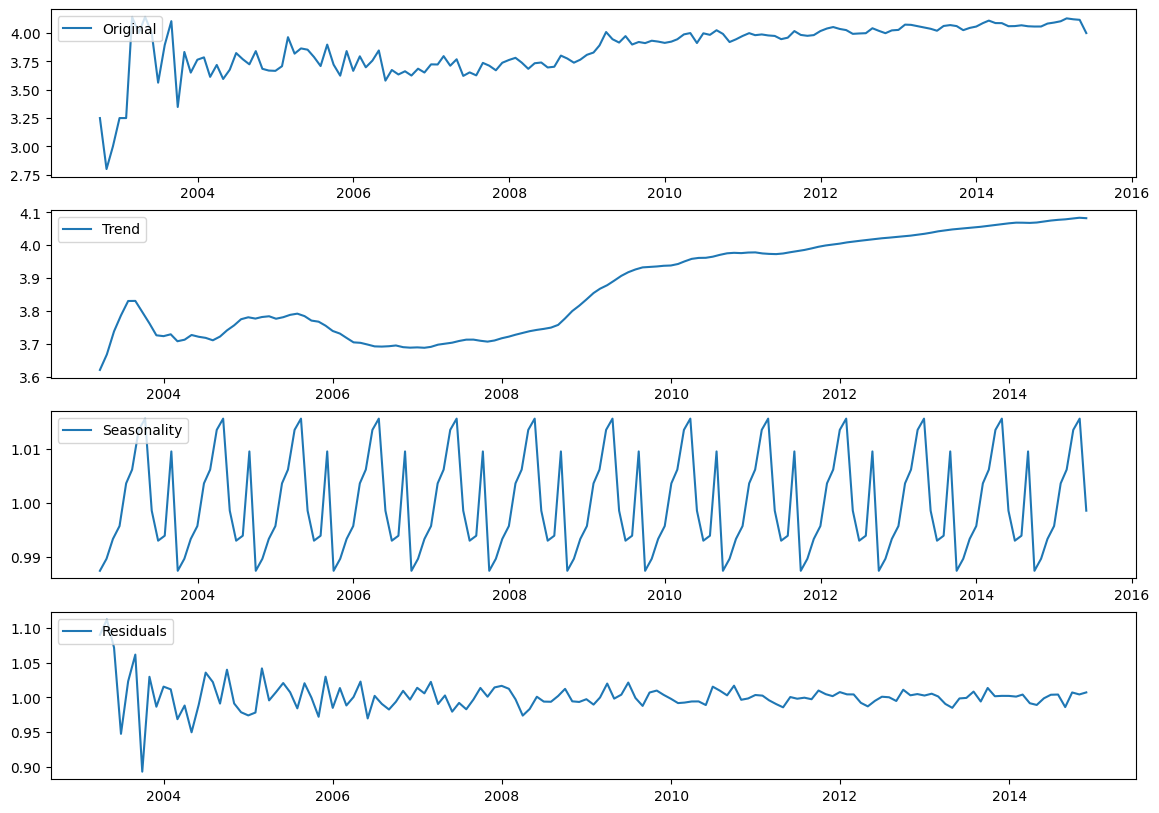

In [ ]:
# Perform seasonal decomposition of the annual data to identify trend and pattern
decomposition = seasonal_decompose(monthly_data.dropna(), model='multiplicative')  # Assuming an additive model initially

# Plot the decomposition to visualize trend, seasonality, and residuals
plt.figure(figsize=(14, 10))

components = {
    'Original': decomposition.observed,
    'Trend': decomposition.trend,
    'Seasonality': decomposition.seasonal,
    'Residuals': decomposition.resid
}

for i, (label, component) in enumerate(components.items(), start=1):
    plt.subplot(4, 1, i)
    plt.plot(component, label=label)
    plt.legend(loc='upper left')

Multiplicative Model Explanation:  
* The chart presents the same decomposition under a multiplicative model, which is used when seasonal variations are proportional to the level of the time series.
* Components of Multiplicative Model: This includes the original data showing similar fluctuations, a visible upward trend that captures an increasing pattern in the data, pronounced seasonal peaks that scale with the trend, and relatively consistent residuals close to 1, suggesting the model fits well.

Compare between different models:  
* Seasonal Patterns received from `Deseasonalize`: 
    In both models, the seasonality shows clear periodic patterns, but the amplitude of seasonal changes in the multiplicative model increases as the data values rise, unlike in the additive model where these fluctuations are constant.
* Trend and Residuals Comparison: 
    The trend in both models highlights an overall increase, yet the multiplicative model more clearly aligns with increasing seasonal peaks, and the residuals in both models suggest the selected model structures adequately capture the underlying patterns with only minor unexplained variations.

### Summary

The series of analyses provides a detailed examination of review data through various statistical techniques, capturing trends, seasonality, and the distribution of reviews over time. The presentation begins by plotting the historical trend of mean overall ratings monthly, highlighting both fluctuations and a noticeable improvement in ratings over the years. A histogram underscores the growth in the total number of reviews annually, with a significant uptick observed from 2004 to 2012, followed by a decline. Another analysis involves monthly overall ratings with a two-month moving average, showing how smoothing techniques clarify underlying trends amidst data volatility. The concluding segments delve into seasonal decompositions of the data under additive and multiplicative models, isolating and contrasting trends, seasonal effects, and residuals to discern underlying patterns. These patterns indicate that seasonal impacts are more accentuated under the multiplicative model as it aligns with the increasing scale of the data. This comprehensive analysis is crucial for understanding consumer sentiment, offering essential insights into customer satisfaction and business performance over time.

## Clustering

- Clustering can be applied to our dataset by grouping similar reviews, destinations, or trip type,  based on features like overall rating, value ratings, or location. For example, using k-means clustering, we can identify clusters of reviews with similar sentiment or categorize destinations by types (solo, family etc). This helps in offering personalized recommendations or grouping similar experiences. 

In [ ]:
"""
Load the reduced data again from csv and run Shapiro test.
"""
path = "../dataset/The final data set (uncentered and unscaled variables).csv"
rating_df = pd.read_csv(path)
print(f"Shape of dataset: {rating_df.shape}")

Shape of dataset: (1048575, 80)


In [ ]:
"""
Show the null fields in the dataset. Tools: isnull()
"""
# Return checking results from all columns in df.
ck_results_isnull = rating_df.isnull().sum() 

# Keep the specific columns including missing values, (Condidion: ck_results_isnull > 0).
missing_values_cols = ck_results_isnull[ck_results_isnull > 0]
print(f"Missing values: \n{missing_values_cols}")

Missing values: 
Location_rating            229128
Cleanliness_rating         200559
Rooms_rating               255351
Service_rating              93225
Sleepquality_rating        313724
Value_rating               198890
Date_of_review              93050
Trip_type                  134225
Reviewer_rank              206794
Hotel.stars                 22838
Hotel.price                 82560
Hotel.distance              18773
Hotel.noofrooms              4412
Destination_country_GDP      6555
Visitors_country_GDP         4189
Visitors_country_pdi        24428
Visitors_country_idv        24428
Visitors_country_mas        24428
Visitors_country_uai        24428
Visitors_country_lto        29408
Visitors_country_ivr        46917
dtype: int64


In [ ]:
# Checking features that are considered numeric in our dataset
print(rating_df.select_dtypes(include=['number']).columns)

Index(['Review_id', 'Destination_country_id', 'Visitors_country_id',
       'Overall_rating', 'Location_rating', 'Cleanliness_rating',
       'Rooms_rating', 'Service_rating', 'Sleepquality_rating', 'Value_rating',
       'Hotel.stars', 'Hotel.price', 'Hotel.distance', 'Hotel.noofrooms',
       'Suites', 'Family.Rooms', 'Microwave', 'Air.Conditioning', 'Minibar',
       'Refrigerator.in.room', 'Bar.Lounge', 'Kitchenette', 'Free.Parking',
       'Self.Serve.Laundry', 'Business.Centre.with.Internet.Access',
       'Conference.Facilities', 'Meeting.Rooms', 'Banquet.Room',
       'Casino.and.Gambling', 'Babysitting', 'Dry.Cleaning',
       'Multilingual.Staff', 'Airport.Transportation', 'Free.Breakfast',
       'Children.Activities...Kid...Family.Friendly..', 'Laundry.Service',
       'Concierge', 'Room.Service', 'Restaurant', 'Shuttle.Bus.Service',
       'Free.Internet', 'Free.High.Speed.Internet...WiFi..', 'Paid.Wifi',
       'Paid.Internet', 'Public.Wifi', 'Ski.In...Ski.Out',
       'F

In [ ]:
# Change data types to ID features that are considered numerical
columns_to_change = ["Review_id", "Destination_country_id", "Visitors_country_id"]
rating_df[columns_to_change] = rating_df[columns_to_change].astype("object")

In [ ]:
# Check skew values of numerical columns
numeric_cols = rating_df.select_dtypes(include=['number'])
skew_values = numeric_cols.skew().sort_values(ascending=False)
print(skew_values)

Ski.In...Ski.Out                                 46.417328
Hotel.distance                                   30.113650
Beach                                             9.561702
Casino.and.Gambling                               8.408424
Golf.course                                       7.320577
Microwave                                         6.309580
Hotel.noofrooms                                   4.110821
Smoking.rooms.available                           3.231902
Refrigerator.in.room                              3.096548
Reduced.mobility.rooms                            2.772784
Kitchenette                                       2.460685
Children.Activities...Kid...Family.Friendly..     2.173229
Hotel.price                                       2.018419
Tennis.Court                                      1.638959
Hot.Tub                                           1.609551
Minibar                                           1.582044
Conference.Facilities                             1.5141

### Normalize numerical features using appropriate method based on feature characteristics.
* Strategies:   
Right Skewed（Skewness > 1） → Log Transformation (Compress the long tail)  
Left Skewed（Skewness < -1） → Log Transformation (Compress the long tail)  
Close to symetric（-1 ≤ Skewness ≤ 1） → Z-score Scaling（Keep in the same period）  

In [ ]:
rating_df_numeric = rating_df.select_dtypes(include=['number']).copy()
skewness = rating_df_numeric.skew()

SKEWNESS_THRESHOLD = 1 # 0.5

# Fill missing values & Run Normalization
for col in rating_df_numeric.columns:
    if skewness[col] > SKEWNESS_THRESHOLD or skewness[col] < SKEWNESS_THRESHOLD: # Left or right Skewed
        rating_df_numeric[col] = rating_df_numeric[col].fillna(rating_df_numeric[col].median())
        rating_df_numeric[col] = np.log1p(rating_df_numeric[col])
    else:  # Symetric
        rating_df_numeric[col] = rating_df_numeric[col].fillna(rating_df_numeric[col].mean())
        scaler = StandardScaler()
        rating_df_numeric[col] = scaler.fit_transform(rating_df_numeric[[col]])

print("Numerical features summary statistics:")
display(rating_df_numeric.describe())

print("\nFirst 5 rows for numerical features:")
display(rating_df_numeric.head())

Numerical features summary statistics:


,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel.stars,Hotel.price,Hotel.distance,Hotel.noofrooms,Suites,Family.Rooms,Microwave,Air.Conditioning,Minibar,Refrigerator.in.room,Bar.Lounge,Kitchenette,Free.Parking,Self.Serve.Laundry,Business.Centre.with.Internet.Access,Conference.Facilities,Meeting.Rooms,Banquet.Room,Casino.and.Gambling,Babysitting,Dry.Cleaning,Multilingual.Staff,Airport.Transportation,Free.Breakfast,Children.Activities...Kid...Family.Friendly..,Laundry.Service,Concierge,Room.Service,Restaurant,Shuttle.Bus.Service,Free.Internet,Free.High.Speed.Internet...WiFi..,Paid.Wifi,Paid.Internet,Public.Wifi,Ski.In...Ski.Out,Fitness.Centre.with.Gym...Workout.Room,Spa,Tennis.Court,Hot.Tub,Pool,Golf.course,Beach,Wheelchair.access,Reduced.mobility.rooms,Non.Smoking.Hotel,Non.Smoking.Rooms,Smoking.rooms.available,Pets.Allowed...Dog...Pet.Friendly..,Destination_country_GDP,Visitors_country_GDP,Destination_country_pdi,Destination_country_idv,Destination_country_mas,Destination_country_uai,Destination_country_lto,Destination_country_ivr,Visitors_country_pdi,Visitors_country_idv,Visitors_country_mas,Visitors_country_uai,Visitors_country_lto,Visitors_country_ivr
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.587331e+00,1.689830e+00,1.668819e+00,1.581796e+00,1.603557e+00,1.612199e+00,1.580046e+00,1.548115e+00,4.909527e+00,1.260795e+00,4.856325e+00,4.216321e-01,4.720262e-01,1.620004e-02,2.439571e-01,1.315623e-01,5.544450e-02,5.150955e-01,7.763024e-02,1.633324e-01,3.255741e-01,4.808775e-01,1.373807e-01,4.893031e-01,3.120823e-01,9.406561e-03,2.639271e-01,4.556960e-01,4.376794e-01,1.509479e-01,2.059594e-01,9.155631e-02,5.144595e-01,4.509312e-01,5.231350e-01,5.256701e-01,1.879091e-01,6.456933e-01,6.151131e-01,1.499993e-01,1.710176e-01,2.560964e-01,3.212641e-04,3.824365e-01,1.859386e-01,1.269020e-01,1.292857e-01,2.403439e-01,1.225233e-02,7.341480e-03,4.690701e-01,6.549029e-02,2.336985e-01,6.130724e-01,5.186565e-02,1.772955e-01,9.997639e+00,1.013563e+01,3.959829e+00,3.828215e+00,3.890949e+00,3.992562e+00,3.887683e+00,3.829366e+00,3.870758e+00,4.054584e+00,3.990497e+00,4.109089e+00,3.766338e+00,3.952207e+00
std,2.514682e-01,1.794903e-01,2.139170e-01,2.240243e-01,2.489474e-01,2.050573e-01,2.348766e-01,1.808122e-01,6.117450e-01,6.740733e-01,1.072996e+00,3.383483e-01,3.230712e-01,1.047214e-01,3.310336e-01,2.718151e-01,1.880349e-01,3.028427e-01,2.185927e-01,2.941700e-01,3.459370e-01,3.194930e-01,2.763181e-01,3.158190e-01,3.448532e-01,8.019759e-02,3.365753e-01,3.289463e-01,3.343846e-01,2.860837e-01,3.167665e-01,2.346902e-01,3.031957e-01,3.304888e-01,2.982271e-01,2.967116e-01,3.081216e-01,1.750448e-01,2.190887e-01,2.854328e-01,2.988201e-01,3.345553e-01,1.491913e-02,3.447132e-01,3.070989e-01,2.680629e-01,2.699987e-01,3.298918e-01,9.133758e-02,7.095656e-02,3.242036e-01,2.027448e-01,3.276775e-01,2.215664e-01,1.823747e-01,3.024207e-01,9.684322e-01,1.091010e+00,4.054930e-01,5.664421e-01,4.633175e-01,5.707401e-01,4.425446e-01,4.191991e-01,4.314513e-01,4.547883e-01,2.528463e-01,3.312598e-01,4.957530e-01,3.680933e-01
min,6.931472e


First 5 rows for numerical features:


,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel.stars,Hotel.price,Hotel.distance,Hotel.noofrooms,Suites,Family.Rooms,Microwave,Air.Conditioning,Minibar,Refrigerator.in.room,Bar.Lounge,Kitchenette,Free.Parking,Self.Serve.Laundry,Business.Centre.with.Internet.Access,Conference.Facilities,Meeting.Rooms,Banquet.Room,Casino.and.Gambling,Babysitting,Dry.Cleaning,Multilingual.Staff,Airport.Transportation,Free.Breakfast,Children.Activities...Kid...Family.Friendly..,Laundry.Service,Concierge,Room.Service,Restaurant,Shuttle.Bus.Service,Free.Internet,Free.High.Speed.Internet...WiFi..,Paid.Wifi,Paid.Internet,Public.Wifi,Ski.In...Ski.Out,Fitness.Centre.with.Gym...Workout.Room,Spa,Tennis.Court,Hot.Tub,Pool,Golf.course,Beach,Wheelchair.access,Reduced.mobility.rooms,Non.Smoking.Hotel,Non.Smoking.Rooms,Smoking.rooms.available,Pets.Allowed...Dog...Pet.Friendly..,Destination_country_GDP,Visitors_country_GDP,Destination_country_pdi,Destination_country_idv,Destination_country_mas,Destination_country_uai,Destination_country_lto,Destination_country_ivr,Visitors_country_pdi,Visitors_country_idv,Visitors_country_mas,Visitors_country_uai,Visitors_country_lto,Visitors_country_ivr
0,1.386294,1.098612,1.386294,1.386294,1.386294,1.386294,1.609438,1.791759,5.023881,2.202765,6.016157,0.693147,0.693147,0.0,0.693147,0.693147,0.0,0.693147,0.000000,0.0,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.000000,8.106364,6.500989,4.262680,3.258097,3.828641,4.394449,2.079442,1.609438,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
1,1.609438,1.791759,1.791759,1.609438,1.791759,1.609438,1.791759,1.386294,4.553877,1.790091,5.525453,0.000000,0.693147,0.0,0.693147,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.693147,0.0,0.000000,10.561906,6.500989,4.007333,3.850148,4.564348,4.532599,4.488636,3.761200,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
2,1.791759,1.791759,1.791759,1.609438,1.791759,1.791759,1.609438,1.791759,5.204007,0.756122,6.752270,0.693147,0.693147,0.0,0.000000,0.000000,0.0,0.693147,0.693147,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.0,0.693147,0.000000,0.693147,0.693147,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.693147,8.106364,6.500989,4.262680,3.258097,3.828641,4.394449,2.079442,1.609438,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
3,1.609438,1.386294,1.791759,1.609438,1.791759,1.609438,1.609438,1.791759,6.505784,1.706565,5.370638,0.693147,0.693147,0.0,0.000000,0.000000,0.0,0.693147,0.000000,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,0.0,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.000000,10.640223,6.500989,3.583519,4.499810,4.204693,3.583519,3.951244,4.248495,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
4,1.386294,1.791759,1.609438,1.386294,1.791759,1.609438,1.791759,1.609438,4.356709,1.128171,3.912023,0.000000,0.000000,0.0,0.693147,0.000000,0.0,0.693147,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.693147,0.0,0.0000

### Elbow method to choose optimal K

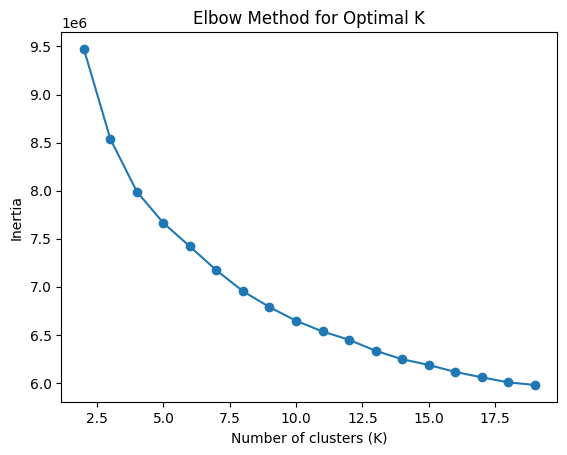

In [ ]:
# Kmeans
MIN_GROUP, MAX_GROUP = 2, 20
inertia = []
K_range = range(MIN_GROUP, MAX_GROUP)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rating_df_numeric)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

### K-Means

WCSS (Within-Cluster Sum of Squares): 7663159.81
BCSS (Between-Cluster Sum of Squares): 3186993.90
Total Sum of Squares (TSS = WCSS + BCSS): 10850153.71


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


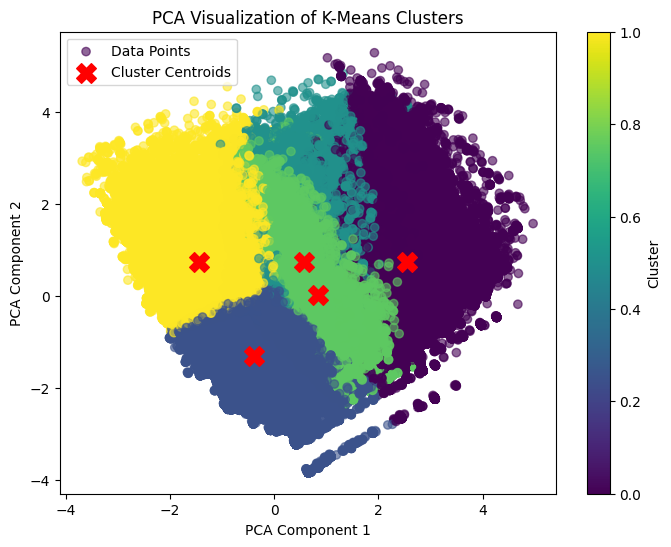

In [ ]:
optimal_k = 5 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

WCSS (Within-Cluster Sum of Squares): 7988960.46
BCSS (Between-Cluster Sum of Squares): 2860547.79
Total Sum of Squares (TSS = WCSS + BCSS): 10849508.25


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


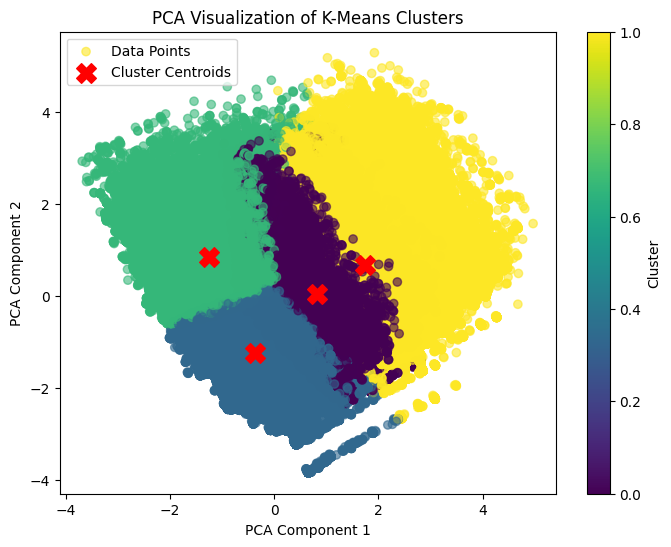

In [ ]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


WCSS (Within-Cluster Sum of Squares): 8537785.09
BCSS (Between-Cluster Sum of Squares): 2312357.77
Total Sum of Squares (TSS = WCSS + BCSS): 10850142.86


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


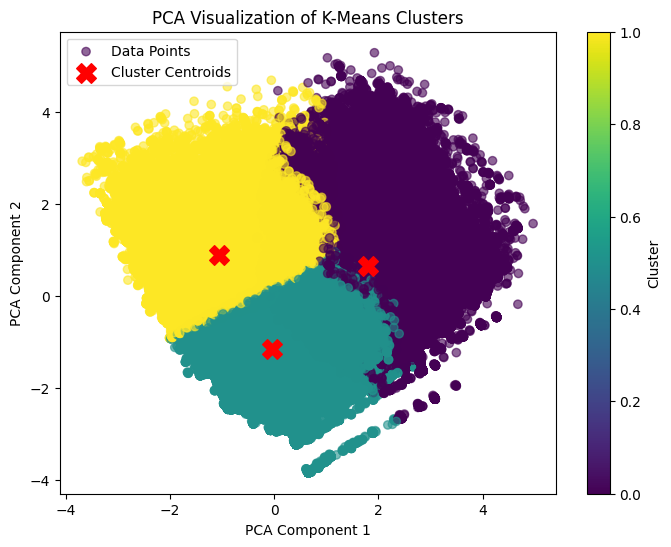

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


### Summary

The K-Means algorithm divided our numerical data into the five clusters, each representing distinct patterns in hotel services and ratings. Using Principal Component Analysis (PCA) to reduce dimensionality, we can see a clear separation between clusters, which suggests meaningful differences across the features we considered. For example, some clusters represent high-rated hotels that offer a wide range of services, while others include budget-friendly options, helping us identify key segments within the hotel market for targeted strategies.

#### Compare different k values:
K=5  
WCSS (Within-Cluster Sum of Squares): 7663159.81  
BCSS (Between-Cluster Sum of Squares): 3186993.90  
Total Sum of Squares (TSS = WCSS + BCSS): 10850153.71  

K=4  
WCSS (Within-Cluster Sum of Squares): 7988960.46  
BCSS (Between-Cluster Sum of Squares): 2860547.79  
Total Sum of Squares (TSS = WCSS + BCSS): 10849508.25  

K=3  
WCSS (Within-Cluster Sum of Squares): 8537785.09  
BCSS (Between-Cluster Sum of Squares): 2312357.77  
Total Sum of Squares (TSS = WCSS + BCSS): 10850142.86

## Classification

### Data fitting

In [ ]:
# Prepare X (features) and y (target)
X = df_final  # Features
y = rating_df["Overall_rating"].apply(lambda x: 1 if x >= 4 else 0)  # Binary classification (Good/Bad rating)
rating_df["Bin_Overall_rating"] = y

- Split dataset into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Choose the best k value for KNN

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 25, 2)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=1) 

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='accuracy')

In [ ]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Cross-Validation Score (Accuracy): {best_score}")

Best n_neighbors: 23
Best Cross-Validation Score (Accuracy): 0.7670076055599266


- Plot the accuracy scores for KNN

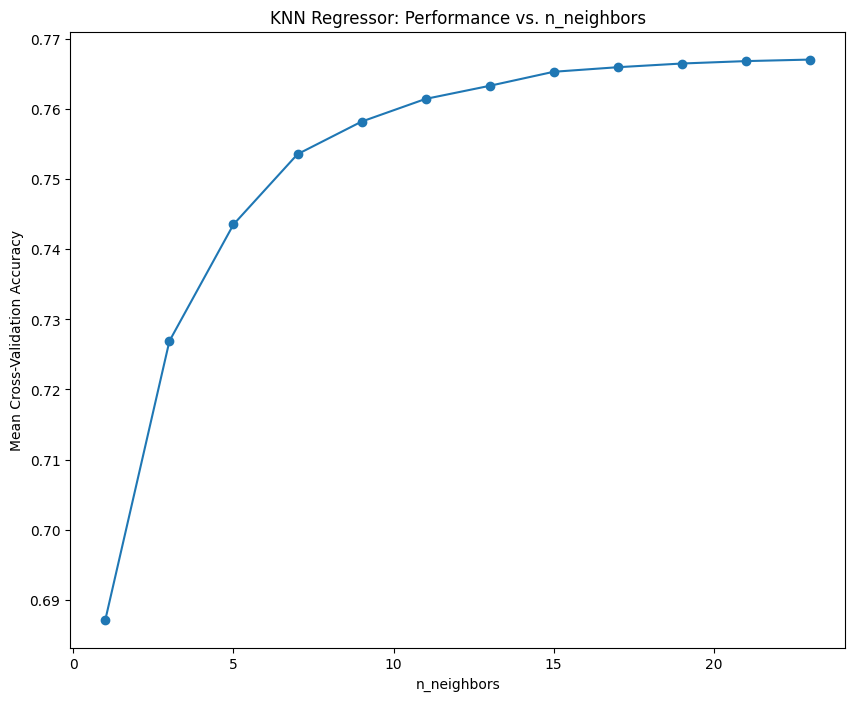

In [ ]:
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10,8))
plt.plot(np.arange(1, 25, 2), mean_scores, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('KNN Regressor: Performance vs. n_neighbors')
plt.show()

In [ ]:
# Initialize KNN model (k=23)
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [ ]:
def evaluate_knn(n, _X_train, _y_train, _X_test, _y_test):
    # Initialize KNN model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(_X_train, _y_train)

    # Make predictions
    _y_pred = knn.predict(_X_test)

    # Evaluate Model
    accuracy = accuracy_score(_y_test, _y_pred)
    conf_matrix = confusion_matrix(_y_test, _y_pred)
    class_report = classification_report(_y_test, _y_pred)

    # Display Results
    print(f"Accuracy: {accuracy:.2f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    return

- Evaluate model for KNN (when k=22)

In [ ]:
evaluate_knn(n=22, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  8346  40809]
 [  8338 152222]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25     49155
           1       0.79      0.95      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.64      0.56      0.56    209715
weighted avg       0.72      0.77      0.72    209715



- Evaluate model for KNN (when k=23)

In [ ]:
evaluate_knn(n=23, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  7081  42074]
 [  6509 154051]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.14      0.23     49155
           1       0.79      0.96      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.65      0.55      0.54    209715
weighted avg       0.72      0.77      0.71    209715



- Evaluate model for KNN (when k=24)

In [ ]:
evaluate_knn(n=24, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  8031  41124]
 [  7766 152794]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.16      0.25     49155
           1       0.79      0.95      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.65      0.56      0.55    209715
weighted avg       0.72      0.77      0.72    209715



- Visualize clusters

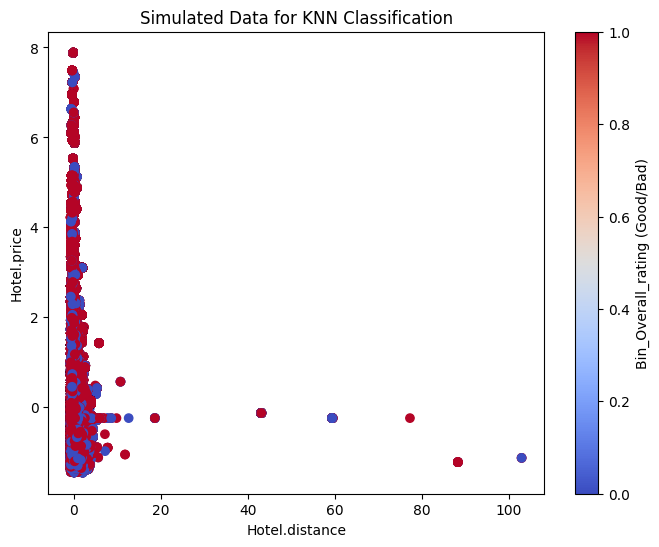

In [ ]:
# Visualize the Clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_final['Hotel.distance'], df_final['Hotel.price'], c=rating_df["Bin_Overall_rating"], cmap='coolwarm')#, alpha=0.7)
plt.xlabel("Hotel.distance")
plt.ylabel("Hotel.price")
plt.title("Simulated Data for KNN Classification")
plt.colorbar(label="Bin_Overall_rating (Good/Bad)")
plt.show()

#### Summary of Solutions
KNN Model Initialization & Prediction

A KNN classifier (k=23) is trained on (X_train, y_train) and predicts y_pred on X_test.
Reusable KNN Evaluation Function

The function evaluate_knn(n, _X_train, _y_train, _X_test, _y_test) trains a KNN model, makes predictions, and evaluates accuracy, confusion matrix, and classification report.
Data Visualization for Insights

A scatter plot (Hotel.distance vs. Hotel.price) is used to observe classification patterns based on binned hotel ratings.
Key Takeaways

Model Training: KNN depends on k-value selection.
Evaluation: evaluate_knn allows easy performance comparison.
Visualization: Helps understand feature impact.
Interpretability: Metrics reveal classification strengths/weaknesses.

## Regression

### Simple Linear Regression (SLR)

### Hypothesis Assumptions for Homoscedasticity:

- **Null hypothesis (H₀):** The residuals of the regression model have constant variance (homoscedasticity).  
- **Alternative hypothesis (H₁):** The residuals of the regression model have non-constant variance (heteroscedasticity).  

**Decision Rule:**  
If the p-value ≤ 0.05, we reject the null hypothesis and conclude that heteroscedasticity may be present.

Note: <br> 
In linear regression, one of the key assumptions is homoscedasticity — which means the residuals (or errors) of the model should have constant variance across all levels of the independent variable.

When this assumption is violated, and the variance of the residuals changes depending on the value of the independent variable, we have what's called heteroscedasticity.heteroscedasticity may lead to invalid test results, inefficient estimates, and unstable predictions.

In [ ]:
# Extract significant predictors from the MLR model
significant_columns = model_mlr.pvalues[model_mlr.pvalues < 0.05].index.tolist()

Checking to see if we can find a higher r-squared regression model using the same target.

In [ ]:
target = "Overall_rating"
models_list = []

for predictor in significant_columns:
    formula_slr = f"{target} ~ {predictor}"
    model = smf.ols(formula=formula_slr, data=transformed_df).fit()

    if model.rsquared > 0.2:
        models_list.append(model)

In [ ]:
for model in models_list:
    print("\nSLR Model Summary:")
    print(model.summary())


SLR Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                 5.918e+05
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:12:09   Log-Likelihood:            -3.3257e+06
No. Observations:             1048575   AIC:                         6.651e+06
Df Residuals:                 1048573   BIC:                         6.651e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

Now we're trying to check all the relationships between all significant columns to see if we can find a better model.

*This code takes 25 minutes to run.*

In [ ]:
current_r2 = model_slr.rsquared
best_models = []

for target in significant_columns:
    for predictor in significant_columns:
        if target != predictor:
            formula = f"{target} ~ {predictor}"
            model = smf.ols(formula=formula, data=transformed_df).fit()

            if model.rsquared > current_r2 and model.rsquared < 1:
                best_models.append((target, predictor, model.rsquared, model))

# Sort models by R-squared (descending order)
best_models.sort(key=lambda x: x[2], reverse=True)

# Display the best models
if best_models:
    print(f"\nTop {min(5, len(best_models))} Better Models Found:")
    for i, (target, predictor, r2, model) in enumerate(best_models[:5]):
        print(f"{i+1}. {target} ~ {predictor} | R² = {r2:.3f}")
        print(model.summary())

In [ ]:
## printing the best regression model
best_target = 'Visitors_country_GDP '
best_predictor = 'Visitors_country_idv'

best_formula = f"{best_target} ~ {best_predictor}"
best_model = smf.ols(formula=best_formula, data=transformed_df).fit()
print("\nSLR Best model summary:")
print(best_model.summary())


SLR Best model summary:
                             OLS Regression Results                             
Dep. Variable:     Visitors_country_GDP   R-squared:                       0.779
Model:                              OLS   Adj. R-squared:                  0.779
Method:                   Least Squares   F-statistic:                 3.695e+06
Date:                  Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                          16:13:45   Log-Likelihood:            -1.1182e+07
No. Observations:               1048575   AIC:                         2.236e+07
Df Residuals:                   1048573   BIC:                         2.236e+07
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

- Plot the potential relationships

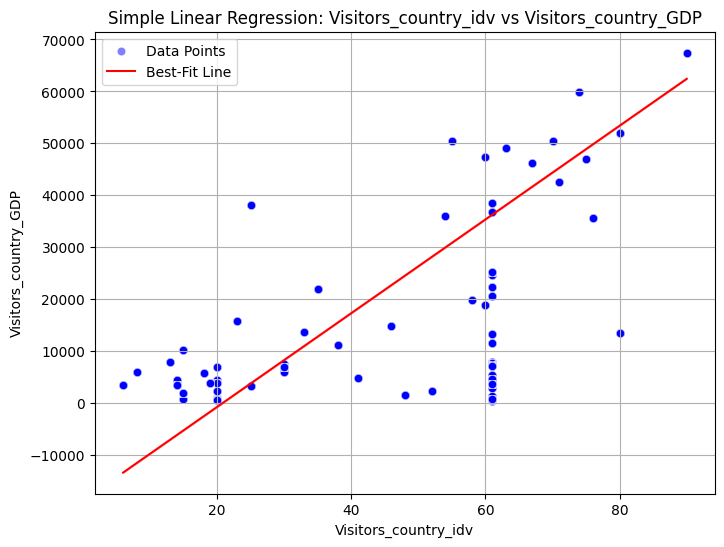

In [ ]:
# Plot for SLR
X = transformed_df['Visitors_country_idv'] # clean_df['Visitors_country_GDP']
y = transformed_df['Visitors_country_GDP'] # clean_df['Visitors_country_idv']

y_pred = best_model.fittedvalues

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X, y=y, color='blue', alpha=0.5, label='Data Points')
sns.lineplot(x=X, y=y_pred, color='red', label='Best-Fit Line')

plt.xlabel('Visitors_country_idv')
plt.ylabel('Visitors_country_GDP')
plt.title('Simple Linear Regression: Visitors_country_idv vs Visitors_country_GDP')
plt.legend()
plt.grid(True)
plt.show()

- Homoscedasticity analsis for the SLR restuls

- Plots residuals: This function plots residuals vs. predicted values. If the points are randomly scattered around zero, it suggests homoscedasticity. But if there's a pattern (e.g. funnel shape), it suggests heteroscedasticity.

- breusch_pagan_test:  
This function uses the Breusch-Pagan test to statistically test for heteroscedasticity.  
It retrieves the residuals and exogenous variables, runs the test, and prints the p-value.
If p > 0.05, we fail to reject the null hypothesis, meaning homoscedasticity is likely.  <br>
If p ≤ 0.05, we reject the null, indicating possible heteroscedasticity. <br>

In [ ]:
"""
This code checks for homoscedasticity (constant variance of residuals) in a regression model using two methods: 
a residual plot and the Breusch-Pagan test.
These functions help diagnose model reliability and guide necessary corrections.
"""
from statsmodels.stats.diagnostic import het_breuschpagan
import pandas as pd

def homoscedasticity_plot(_model):
    """
    Plots residuals vs. predicted values to visually inspect homoscedasticity.

    A random spread around zero suggests homoscedasticity, while patterns indicate heteroscedasticity.
    """
    # Homoscedasticity
    predicted_values = _model.fittedvalues
    residuals = _model.resid

    # Residual Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predicted_values, y=residuals)#ß, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Homoscedasticity Check')
    plt.show()
    return

def breusch_pagan_test(_model):
    """
    Uses the Breusch-Pagan test to statistically detect heteroscedasticity.

    Outputs a p-value, where:
    - p > 0.05 suggests no heteroscedasticity (assumption holds),
    - p ≤ 0.05 indicates heteroscedasticity (assumption is violated).

    Lagrange Multiplier statistic: 
    This is the test statistic calculated based on the Breusch-Pagan method. 
    It measures how strongly the variance of residuals depends on the independent variables.

    p-value (LM): 
    The p-value associated with the Lagrange Multiplier statistic. 
    If p ≤ 0.05, it suggests significant evidence **against** the null hypothesis of homoscedasticity, 
    indicating that heteroscedasticity may be present.

    F-statistic: 
    An alternative version of the test statistic based on the F-distribution.
    It serves the same purpose — to test for heteroscedasticity.

    p-value (F): 
    The p-value corresponding to the F-statistic. 
    Again, if p ≤ 0.05, it suggests significant evidence of heteroscedasticity.
    """
    # Get residuals and input variables (exogenous variables)
    residuals = _model.resid
    exog = _model.model.exog

    # Run the Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(residuals, exog)

    # Organize the test result with labels
    bp_labels = ['Lagrange Multiplier statistic', 'p-value (LM)', 'F-statistic', 'p-value (F)']
    bp_results = pd.Series(bp_test, index=bp_labels)

    # Print the test results
    print("Breusch-Pagan Test for Homoscedasticity:\n")
    print(bp_results)

    # Interpret the p-value result
    print("\nInterpretation:")
    if bp_results['p-value (LM)'] > 0.05:
        print("p-value > 0.05: No significant evidence of heteroscedasticity. The homoscedasticity assumption is likely satisfied.")
    else:
        print("p-value ≤ 0.05: Evidence of heteroscedasticity detected. The homoscedasticity assumption may be violated.")
    return

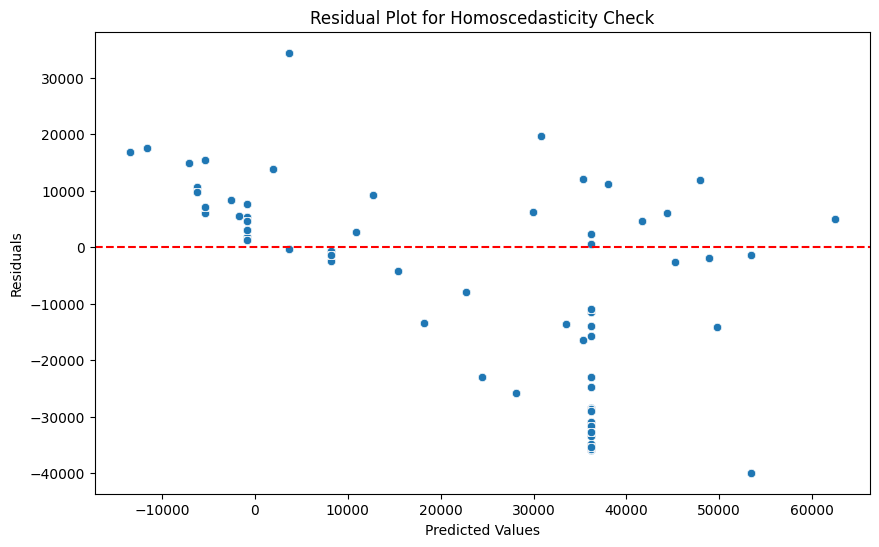

Breusch-Pagan Test for Homoscedasticity:

Lagrange Multiplier statistic   51421.22
p-value (LM)                        0.00
F-statistic                     54072.80
p-value (F)                         0.00
dtype: float64

Interpretation:
p-value ≤ 0.05: Evidence of heteroscedasticity detected. The homoscedasticity assumption may be violated.


In [ ]:
homoscedasticity_plot(best_model)

breusch_pagan_test(best_model)

Note: Despite a good R-squared value (0.779), the residuals show evidence of heteroscedasticity, indicating a violation of the constant variance assumption.

### Summary

- We found out that the best simple linear regression (SLR) model explains the relationship between `Visitors_country_GDP` and `Visitors_country_idv` with an R-squared value of 0.779, indicating that 77.9% of the variation in GDP is explained by individualism scores (IDV). This is a strong relationship, suggesting that countries with higher individualism scores tend to have higher GDP.

- The regression coefficient of 903.02 implies that for every 1-unit increase in IDV, the GDP increases by approximately $903 per capita, holding other factors constant. The very small F-statistic and p-value of 0 confirm that the relationship is statistically significant. 

- Compared to the previous SLR model (`Overall_rating` ~ `Service_rating`, R² = 0.525), this new model has a substantially better fit (R² increased from 52.5% to 77.9%). This suggests that economic and cultural factors have a stronger linear relationship than customer satisfaction metrics in the previous model. 

- However, while this model performs better in explaining GDP variation, log-likelihood (-1.1182e+07), AIC (2.236e+07), and BIC (2.236e+07) indicate that there may still be missing explanatory variables. Factors such as technological advancement, political stability, or education levels could further improve the model's predictive accuracy. Additionally, the Durbin-Watson statistic (0.000) suggests potential autocorrelation, which may indicate that time-series or regional effects are influencing the data.

### Multiple Linear Regression (MLR)

In [ ]:
# MLR using only significant columns
formula_mlr = "Overall_rating ~ " + " + ".join(significant_columns)

# Fit the model
model_mlr = smf.ols(formula=formula_mlr, data=transformed_df).fit()

# Print the model summary
print("\nMLR Model Summary:")
print(model_mlr.summary())


MLR Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 3.212e+04
Date:                Sat, 29 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:44:14   Log-Likelihood:            -2.9753e+06
No. Observations:             1048575   AIC:                         5.951e+06
Df Residuals:                 1048507   BIC:                         5.952e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

We still use over 60 features, which might indicate strong multicollinearity. Let's see if removing strong correlations between variables might help our MLR model perform better.

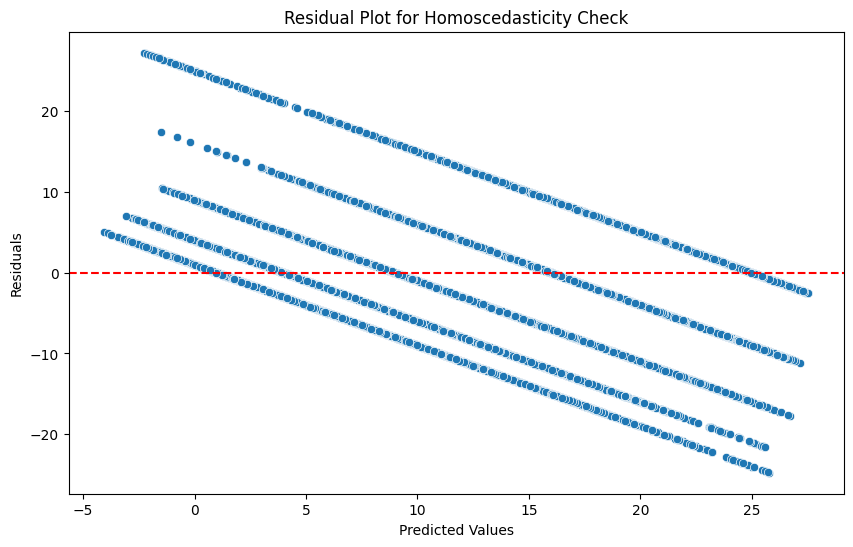

Breusch-Pagan Test for Homoscedasticity:

Lagrange Multiplier statistic   109695.15
p-value (LM)                         0.00
F-statistic                       1775.41
p-value (F)                          0.00
dtype: float64

Interpretation:
p-value ≤ 0.05: Evidence of heteroscedasticity detected. The homoscedasticity assumption may be violated.


In [ ]:
# # Homoscedasticity
homoscedasticity_plot(model_mlr)

breusch_pagan_test(model_mlr)

Note: 
The multiple linear regression model built to predict Overall_rating using several significant features achieves a relatively high R-squared value of 0.672, suggesting a good overall model fit. Most predictors are statistically significant with p-values close to 0, meaning they contribute meaningfully to the prediction of the target variable. <br>
However, the Breusch–Pagan test for homoscedasticity returns a p-value of 0.00, indicating strong evidence against the null hypothesis of constant variance in residuals. This suggests the presence of heteroscedasticity, which violates one of the key assumptions of linear regression.

In [ ]:
# MLR using high correlation filtered columns 
highc_filtered_df.columns = highc_filtered_df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Removes non-alphanumeric characters
encoded_df.columns = encoded_df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Removes non-alphanumeric characters

formula_mlr = "Overall_rating ~ " + " + ".join(highc_filtered_df.columns)

# Fit the model
model_mlr_h = smf.ols(formula=formula_mlr, data=encoded_df).fit()

# Print the model summary
print("\nMLR Model Summary:")
print(model_mlr_h.summary())


MLR Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2667.
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:08:03   Log-Likelihood:                -5540.5
No. Observations:             1048575   AIC:                         1.114e+04
Df Residuals:                 1048547   BIC:                         1.147e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

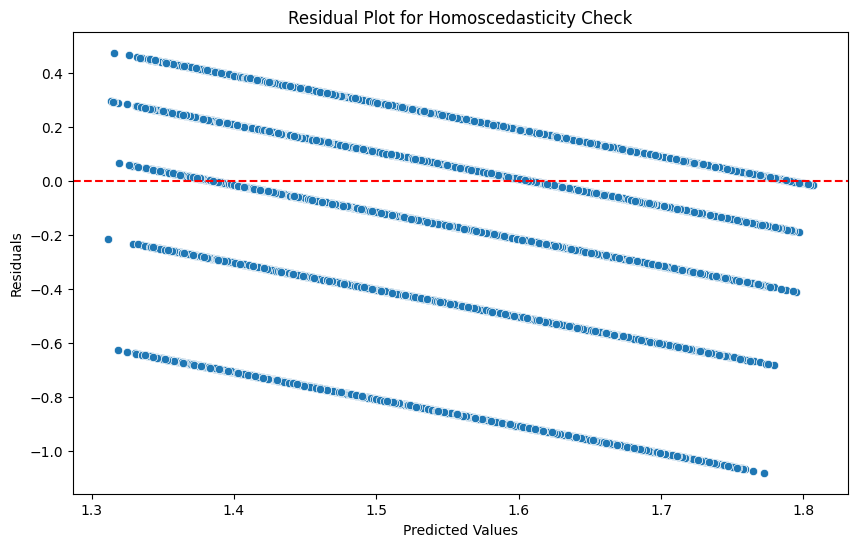

Breusch-Pagan Test for Homoscedasticity:

Lagrange Multiplier statistic   26612.34
p-value (LM)                        0.00
F-statistic                      1011.28
p-value (F)                         0.00
dtype: float64

Interpretation:
p-value ≤ 0.05: Evidence of heteroscedasticity detected. The homoscedasticity assumption may be violated.


In [ ]:
# Homoscedasticity
homoscedasticity_plot(model_mlr_h)
breusch_pagan_test(model_mlr_h)

Note: the residual plot displays a clear striped pattern, and the Breusch–Pagan test reports a p-value of 0.00, providing strong evidence of heteroscedasticity. This violates the homoscedasticity assumption of linear regression, meaning that the variance of residuals is not constant across all levels of predicted values.

Although we are using only the features after filtered by the high correlations, the r-squared is very low. By changing the target variable we can try to improve the model.

In [ ]:
correlation_sums = {}
top_6_features = {}

# Loop through each column to use it as the target variable
for target_variable in highc_filtered_df.columns:
    # Calculate the absolute correlations of the target variable with all other variables
    correlations_with_target = highc_filtered_df.corr()[target_variable].abs().sort_values(ascending=False)
    
    # Exclude the target variable itself (i.e., correlation of the target variable with itself)
    correlations_with_target = correlations_with_target[correlations_with_target.index != target_variable]
    
    # Sum the top 6 highest absolute correlations
    top_6_correlations = correlations_with_target.head(6)
    correlation_sum = top_6_correlations.sum()
    
    # Store the sum and top 6 features for this target variable
    correlation_sums[target_variable] = correlation_sum
    top_6_features[target_variable] = top_6_correlations.index.tolist()

# Find the target variable with the highest sum of correlations
best_target = max(correlation_sums, key=correlation_sums.get)

# Get the top 6 features for the best target
best_top_6_features = top_6_features[best_target]

# Print the best target and its correlation sum along with the top 6 features
print(f"The best target variable is '{best_target}' with a sum of top 6 absolute correlations: {correlation_sums[best_target]}")
print(f"Top 6 correlated features for the best target variable: {best_top_6_features}")

# To remove features with low correlation, simply keep the ones in the best_top_6_features list
features_to_keep = best_top_6_features
features_to_remove = [col for col in highc_filtered_df.columns if col not in features_to_keep]

print(f"Features to keep: {features_to_keep}")
print(f"Features to remove: {features_to_remove}")

The best target variable is 'Hotelstars' with a sum of top 6 absolute correlations: 2.432207213458576
Top 6 correlated features for the best target variable: ['BusinessCentrewithInternetAccess', 'Hotelnoofrooms', 'Babysitting', 'Concierge', 'Wheelchairaccess', 'DryCleaning']
Features to keep: ['BusinessCentrewithInternetAccess', 'Hotelnoofrooms', 'Babysitting', 'Concierge', 'Wheelchairaccess', 'DryCleaning']
Features to remove: ['Destination_country_id', 'Visitors_country_id', 'Hotelstars', 'FamilyRooms', 'AirConditioning', 'SelfServeLaundry', 'MultilingualStaff', 'FreeBreakfast', 'NonSmokingHotel', 'Destination_country_GDP', 'Visitors_country_GDP', 'Destination_country_mas', 'Destination_country_uai', 'Destination_country_lto', 'Destination_country_ivr', 'Visitors_country_mas', 'Visitors_country_uai', 'Visitors_country_lto', 'Trip_type_couple', 'Reviewer_rank', 'Date_of_review']


In [ ]:
## MLR using the best target variable
encoded_df.columns = encoded_df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Removes non-alphanumeric characters

formula_mlr = "Hotelstars ~ " + " + ".join(best_top_6_features)

# Fit the model
model_mlr = smf.ols(formula=formula_mlr, data=encoded_df).fit()

# Print the model summary
print("\nMLR Model Summary:")
print(model_mlr.summary())


MLR Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Hotelstars   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                 1.221e+05
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:15:48   Log-Likelihood:            -1.2101e+06
No. Observations:             1048575   AIC:                         2.420e+06
Df Residuals:                 1048568   BIC:                         2.420e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

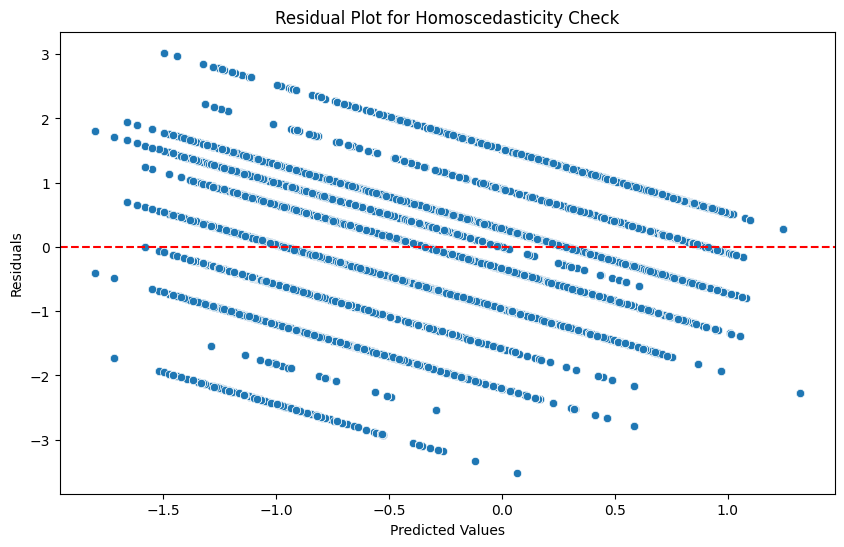

Breusch-Pagan Test for Homoscedasticity:

Lagrange Multiplier statistic   31102.19
p-value (LM)                        0.00
F-statistic                      5342.12
p-value (F)                         0.00
dtype: float64

Interpretation:
p-value ≤ 0.05: Evidence of heteroscedasticity detected. The homoscedasticity assumption may be violated.


In [ ]:
homoscedasticity_plot(model_mlr)

breusch_pagan_test(model_mlr)

Note: The residual plot shows a clear banded, downward pattern, suggesting heteroscedasticity. This is confirmed by the Breusch–Pagan test, which reports a p-value of 0.00, leading to the rejection of the null hypothesis of constant variance. Thus, the model violates the homoscedasticity assumption of linear regression.

### Summary



This project explored multiple linear regression (MLR) models to predict various target variables such as Overall_rating, Visitors_country_GDP, and Hotelstars, using different sets of features selected by significance and correlation. While some models, particularly the simple regression for Visitors_country_GDP (R² = 0.779) and the refined MLR model for Hotelstars (R² = 0.411), demonstrated acceptable explanatory power, all models consistently failed the assumption of homoscedasticity. Residual plots revealed clear non-constant variance patterns, and the Breusch–Pagan tests returned p-values close to 0, confirming the presence of heteroscedasticity. Moreover, evidence of multicollinearity appeared in models with a high condition number. These violations of regression assumptions suggest that while the models are statistically significant, their reliability is limited. To improve model robustness and inference validity, it is recommended to use heteroscedasticity-robust standard errors, perform multicollinearity diagnostics (e.g., VIF), or consider alternative modeling approaches such as regularized regression or tree-based methods.